In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pwd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import numpy as np
import pandas as pd
import numpy as np
# import cv2

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# from torchvision.models import resnet34
from torchvision.models import AlexNet

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import librosa
from librosa.display import specshow
from librosa.display import waveshow
from librosa.feature import melspectrogram
from librosa.feature import mfcc



###### Exploratory analysis

###### Case study

In [105]:
"""
Wave & features
"""
def transform_image(resize_shape=(256, 256)):
    data_transform = transforms.Compose([
            transforms.Resize(resize_shape),
            transforms.ToTensor()
            ])
    return data_transform
    

def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def get_wave(path, sr=None):
    wav, sr = librosa.load(path, sr=sr)
    return wav, sr


def get_feature(wav,
                data_transform=transform_image(resize_shape=(256, 256)),
                power_to_db=True,
                to_img=True,
                feature=melspectrogram,
                sr=None,
                n_fft=2048, 
                hop_length=512, 
                n_mels=128, 
                fmin=20, 
                fmax=8300, 
                top_db=80):
    
    spec = feature(wav, 
                  sr=sr,
                  n_fft=n_fft,
                  hop_length=hop_length,
                  n_mels=n_mels,
                  fmin=fmin,
                  fmax=fmax)

    if power_to_db:
        spec = librosa.power_to_db(spec, top_db=top_db)
    
    if to_img:
        spec = spec_to_image(spec)
    
    if data_transform is not None:
        spec = Image.fromarray(spec)
        spec = data_transform(spec)    
        
    return spec



"""
Plot
"""
def plot_audio(path):
    return ipd.Audio(path)


def plot_wave(wav, title="wave"):
    waveshow(wav, x_axis='time')
    plt.title(title)
    plt.show()
    
    
def plot_feature(feature, title="melspectrogram"): ### ???
    specshow(feature, x_axis='time', y_axis='hz')  ### ???
    plt.colorbar()
    plt.title(title)
    plt.show()
    

    
"""
Case study
"""
def audio_info(path, 
               sr=None, 
               features_dct={"melspectrogram": melspectrogram,
                             "mfcc": mfcc}):

    wav, sr = librosa.load(path, sr=sr)
    plot_wave(wav)
    for name, feature in features_dct.items():
        f = get_feature(wav, sr=sr, feature=feature)
        plot_feature(f, title=name)
    return plot_audio(path)

In [ ]:
# audio_info('drive/MyDrive/DEEPSOUND/ESC-50-master/audio/1-100032-A-0.wav')
audio_info('../ESC-50-master/audio/1-100032-A-0.wav')

###### Construct Datasets

In [186]:
"""
DF
"""
def _rename_targets(df):
    map_dct = dict()
    for i, target in enumerate(df.target.unique()):
        map_dct[target] = i
    df.target = df.target.map(map_dct)
    return df
        
    
def _get_df(path, only_esc10=True):
    df = pd.read_csv(path)
    if only_esc10:
        print(f"Use only 10 classes!")
        print()
        df = df[df.esc10 == True]
        df = _rename_targets(df)
    return df


def _get_target_description(df):
    return df[["target", "category"]].groupby("target").first()


def _get_target_distribution(df, title="distribution_of_targets", ax=None, show=False):    
    ax = df.target.hist(bins=50, alpha=0.5, edgecolor="black", ax=ax)
    ax.set_xlabel("target")
    ax.set_ylabel("number_of_data_points")
    _min = df.target.min()
    _max = df.target.max() + 1
    plt.xticks(np.arange(_min, _max, 1))
    if show:
        plt.title(title)
        plt.show()
    else:
        return ax
    
    
def _get_folds(df):
    fold_dct = dict()
    for fold in df.fold.unique():
        fold_dct[fold] = df[df.fold == fold]
    return fold_dct


def _get_folds_info(dct):
    print(f"Number_of_folds: {len(dct)}")
    print()
    for i, fold in dct.items():
        print(f"fold: {i} | size: {fold.shape[0]}")
    print()
    
    
def _get_folds_distribution(dct):
    print("Distribution of targets across folds:")
    fig, axs = plt.subplots(nrows=1, ncols=len(dct), figsize=(20, 2), sharey=True)
    for i, fold in dct.items():
        _ax = axs[i - 1]
        _get_target_distribution(fold, ax=_ax)
        _ax.set_title(f"fold_{i}")
    plt.show()         

    
def _get_number_of_classes(df):
    return df.target.unique().shape[0]


def _get_point_from_df(df, 
                       ind=0, 
                       base_dir='../ESC-50-master/audio', 
                       in_col='filename', 
                       out_col='target',
                       feature=melspectrogram):
    
    row = df.iloc[ind]
    file_name = row[in_col]
    label = row[out_col]

    file_path = os.path.join(base_dir, file_name)            
    wav, sr = get_wave(file_path)
    point_feature = get_feature(wav, sr=sr, feature=feature) ### to remake
    return point_feature, label


def _train_test_split(df, test_fold=1):
    train_df = df[df.fold != test_fold]
    test_df = df[df.fold == test_fold]
    return train_df, test_df



"""
Dataset
"""   
class ESC50Data(Dataset):
    
    def __init__(self, 
                 df,
                 feature=melspectrogram,
                 base_dir='../ESC-50-master/audio', 
                 in_col='filename', 
                 out_col='target'):
        
        self.df = df
        self.data = []
        self.labels = []
        self.one_hots = []
        
        labels = df[out_col].unique()
        assert len(labels) == 10 ### to del
        
        enc = LabelBinarizer()
        enc.fit(labels)
        self.enc = enc

        for ind in tqdm(range(len(df))):
            point_feature, label = _get_point_from_df(df, 
                                                      ind=ind, 
                                                      base_dir=base_dir, 
                                                      in_col=in_col, 
                                                      out_col=out_col,
                                                      feature=feature)
            
            self.data.append(point_feature)
#             self.data.append(point_feature[np.newaxis,...])            
            self.labels.append(label)
            self.one_hots.append(enc.transform([label]).flatten())
        
                                        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
#         return self.data[idx], self.one_hots[idx]
        
    
    

    
"""
Loaders
"""
def get_loaders(df,
                base_dir='../ESC-50-master/audio',
                feature=melspectrogram,
                test_fold=None, 
                batch_size=16):
    
    # 1. split
    train_df = df
    test_df = None
    if test_fold is not None:
        train_df, test_df = _train_test_split(df, test_fold=test_fold)

    # 2. loaders
    print("train_data:")
    train_data = ESC50Data(train_df, base_dir=base_dir, feature=feature)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    test_loader = None
    if test_df is not None:
        print("test_data:")
        test_data = ESC50Data(test_df, base_dir=base_dir, feature=feature)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) ### !!!
    
    return train_loader, test_loader


def get_cross_validation_loaders(df,
                                 base_dir='../ESC-50-master/audio',
                                 feature=melspectrogram, 
                                 batch_size=16):
    
    loaders = []
    folds = df.fold.unique()
    for fold in folds:
        print(f"--- FOLD: {fold} ---")
        train_loader, test_loader = get_loaders(df,
                                                base_dir=base_dir,
                                                feature=feature,
                                                test_fold=fold, 
                                                batch_size=batch_size)
        loaders.append((train_loader, test_loader))
        
    return loaders       



"""
Data Storage
"""
class DataStorage:
    
    def __init__(self,
                 base_dir="../ESC-50-master",
                 only_esc10=True,
                 feature=melspectrogram,
                 batch_size=16):
        
        csv_path = os.path.join(base_dir, "meta", "esc50.csv")
        audio_dir_path = os.path.join(base_dir, "audio")
        
        assert os.path.isfile(csv_path)
        assert os.path.isdir(audio_dir_path)
        
        self.csv_path = csv_path
        self.audio_dir_path = audio_dir_path
        self.feature = feature
        self.batch_size = batch_size
        
        df = _get_df(csv_path, only_esc10=only_esc10)
        
        self.df = df
        self.folds = _get_folds(df)
        self.target_description = _get_target_description(df)  
        self.number_of_classes = _get_number_of_classes(df)
        self.random_point_feature = self.get_ind_point_feature(ind=np.random.choice(df.shape[0]))
        self.feature_shape = self.random_point_feature.shape
        
        print(f"Number of points: {self.df.shape[0]}")
        print()
        print(self.get_target_description())
        print()
        print(f"Feature: {feature} | Shape: {self.feature_shape}")
        print()
        self.get_cross_validation_loaders()
        self.get_full_data_loader() ### ???
        
        
    def get_ind_point_feature(self, ind=0):
        point_feature, _ = _get_point_from_df(self.df, 
                                              ind=ind, 
                                              base_dir=self.audio_dir_path, 
                                              feature=self.feature)
        return point_feature
        
        
    def get_folds_description(self):
        _get_folds_info(self.folds)
        
        
    def get_folds_distribution(self):
        _get_folds_distribution(self.folds)
        
        
    def get_target_description(self):
        return self.target_description
    
    
    def get_target_distribution(self):
        _get_target_distribution(self.df, show=True)
        
        
    def get_cross_validation_loaders(self):
        print("------ CONSTRUCT CROSS VALIDATION LOADERS------")
        print()
        self.get_folds_description()
        self.get_folds_distribution()
        self.cross_validation_loaders = \
        get_cross_validation_loaders(self.df,
                                     base_dir=self.audio_dir_path,
                                     feature=self.feature, 
                                     batch_size=self.batch_size)
    
    
    def get_full_data_loader(self):
        print("------ CONSTRUCT FULL DATA LOADER------")
        print()
        print(f"Number of points: {self.df.shape[0]}")
        self.get_target_distribution()
        self.full_data_loader, _ = \
        get_loaders(self.df,
                    base_dir=self.audio_dir_path,
                    feature=self.feature,
                    test_fold=None, 
                    batch_size=self.batch_size)

Use only 10 classes!

Number of points: 400

              category
target                
0                  dog
1             chainsaw
2       crackling_fire
3           helicopter
4                 rain
5          crying_baby
6           clock_tick
7             sneezing
8              rooster
9            sea_waves

Feature: <function melspectrogram at 0x7fc7a8980670> | Shape: torch.Size([1, 256, 256])

------ CONSTRUCT CROSS VALIDATION LOADERS------

Number_of_folds: 5

fold: 1 | size: 80
fold: 2 | size: 80
fold: 3 | size: 80
fold: 4 | size: 80
fold: 5 | size: 80

Distribution of targets across folds:


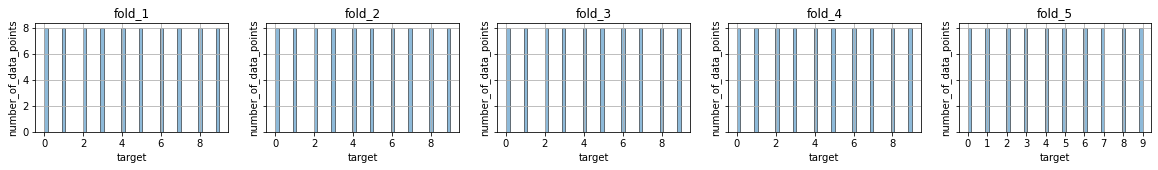

--- FOLD: 1 ---
train_data:


100%|██████████| 320/320 [00:09<00:00, 34.21it/s]


test_data:


100%|██████████| 80/80 [00:02<00:00, 37.76it/s]


--- FOLD: 2 ---
train_data:


100%|██████████| 320/320 [00:06<00:00, 46.15it/s]


test_data:


100%|██████████| 80/80 [00:02<00:00, 38.14it/s]


--- FOLD: 3 ---
train_data:


100%|██████████| 320/320 [00:06<00:00, 46.70it/s]


test_data:


100%|██████████| 80/80 [00:01<00:00, 40.35it/s]


--- FOLD: 4 ---
train_data:


100%|██████████| 320/320 [00:06<00:00, 46.51it/s]


test_data:


100%|██████████| 80/80 [00:01<00:00, 44.42it/s]


--- FOLD: 5 ---
train_data:


100%|██████████| 320/320 [00:06<00:00, 46.82it/s]


test_data:


100%|██████████| 80/80 [00:01<00:00, 48.16it/s]


------ CONSTRUCT FULL DATA LOADER------

Number of points: 400


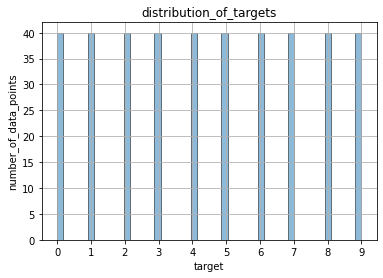

train_data:


100%|██████████| 400/400 [00:10<00:00, 38.40it/s]


In [187]:
DS = DataStorage()

# DS.get_cross_validation_loaders()
# DS.get_full_data_loader()

In [154]:
DS.df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,1,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,2,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,3,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,8,rooster,True,233160,A
1888,5-234879-A-1.wav,5,8,rooster,True,234879,A
1889,5-234879-B-1.wav,5,8,rooster,True,234879,B
1894,5-235671-A-38.wav,5,6,clock_tick,True,235671,A


In [155]:
DS.random_point_feature

tensor([[[0.6039, 0.5333, 0.5059,  ..., 0.7294, 0.7333, 0.7765],
         [0.5804, 0.4980, 0.4667,  ..., 0.7412, 0.7373, 0.7765],
         [0.5294, 0.4275, 0.3843,  ..., 0.7608, 0.7412, 0.7725],
         ...,
         [0.0275, 0.0000, 0.0000,  ..., 0.0157, 0.0039, 0.0353],
         [0.0275, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0314],
         [0.0275, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0275]]])

In [109]:
DS.feature_shape

torch.Size([1, 256, 256])

In [158]:
for batch in DS.full_data_loader:
    print(batch)
    break

[tensor([[[[0.2392, 0.2078, 0.2157,  ..., 0.0000, 0.0000, 0.0000],
          [0.2510, 0.2471, 0.2588,  ..., 0.0000, 0.0000, 0.0000],
          [0.2706, 0.3216, 0.3412,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0706, 0.1176, 0.1098,  ..., 0.0000, 0.0000, 0.0000],
          [0.0980, 0.1137, 0.1059,  ..., 0.0000, 0.0000, 0.0000],
          [0.1098, 0.1098, 0.1020,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.8431, 0.8157, 0.7961,  ..., 0.9020, 0.9412, 0.9020],
          [0.8235, 0.8078, 0.8039,  ..., 0.8549, 0.9059, 0.8745],
          [0.7804, 0.7882, 0.8235,  ..., 0.7647, 0.8314, 0.8157],
          ...,
          [0.2667, 0.1843, 0.1373,  ..., 0.2549, 0.3843, 0.3961],
          [0.2627, 0.1961, 0.1451,  ..., 0.2510, 0.3961, 0.4235],
          [0.2588, 0.2039, 0.1490,  ..., 0.2471, 0.4039, 0.4353]]],


        [[[0.4588, 0.3882, 0.3725,  ..., 0.3255, 0.3333, 0.3294],
          [0.4392, 0.3686, 0.3608,  ..., 0.3137, 0.3059, 0.3216],
          [0.3961, 0.3255, 0.3333,  .

In [159]:
X, y = batch

In [170]:
y

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]])

In [171]:
y.shape

torch.Size([16, 1, 10])

In [ ]:
DS.number_of_classes

In [47]:
np.multiply(*DS.feature_shape)

TypeError: return arrays must be of ArrayType

In [13]:
from PIL import Image

###### MODEL

In [4]:
def get_device():
    return torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


"""
Model
"""
# class Model(nn.Module):
#     def __init__(self, in_dim=1*128*431, out_dim=50):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Linear(in_dim, out_dim))
        
#     def forward(self, xb):
#         x = xb.flatten(start_dim=1)
#         return self.network(x)

    
# class Model(nn.Module):
#     def __init__(self, in_dim=1*128*431, out_dim=50):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, out_dim))
        
#     def forward(self, xb):
#         return self.network(xb)    
    
    
def _init_model(in_dim=1*128*431, out_dim=50):
    
    # 1. custom
#     model = Model(in_dim=in_dim, out_dim=out_dim)
    
    # 2. resnet
    model = resnet34(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=out_dim)
 

    # 3. alexnet
#     model = AlexNet(pretrained=True)
#     model = AlexNet()
#     model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     model.classifier[6] = nn.Linear(in_features=4096, out_features=out_dim)

    model = model.to(device)
    print(model)
    return model


def _get_accuracy(folds_dct):
    
    report_dct = dict()
    accuracies = []
    for fold_num, dct in folds_dct.items():
        y_true = dct["y_true"]
        y_pred = dct["y_pred"]
        
        report_dct[fold_num] = classification_report(y_true, y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))
        
    cros_val_accuracy = np.mean(accuracies)
    
    return report_dct, cros_val_accuracy


"""
Train
"""
def train(model, 
          train_loader, 
          valid_loader,
          epochs=50,
          lr=2e-4,
          gamma=0.96,
          optim=Adam,
          sheduler=ExponentialLR,
          loss_fn=nn.CrossEntropyLoss()):
      
    
    optimizer = optim(model.parameters(), lr=lr)
    lr_scheduler = sheduler(optimizer=optimizer, gamma=gamma)
        
    train_losses = []
    valid_losses = []    
    y_dict = dict()
    
    for epoch in tqdm(range(1, epochs + 1)):
        
        # 1. train
        model.train()        
        lr_scheduler.step()
        
        batch_losses=[]
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            
            y_hat = model(x)
#             print(f"y.shape: {y.shape}")
#             print(f"y: {y}")
#             print()
#             print(f"y_hat.shape: {y_hat.shape}")
#             print(f"y_hat: {y_hat}")
                
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()

        train_loss = np.mean(batch_losses)    
        train_losses.append(train_loss)
        print(f'Epoch: {epoch} | Train_Loss : {train_loss}')
        
        
        # 2. validate
        if valid_loader is not None:
            model.eval()
            batch_losses=[]
            trace_y = []
            trace_y_hat = []

            for i, data in enumerate(valid_loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)

                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                trace_y.append(y.cpu().detach().numpy())
                trace_y_hat.append(y_hat.cpu().detach().numpy())      
                batch_losses.append(loss.item())

            valid_loss = np.mean(batch_losses[-1])    
            valid_losses.append(valid_loss)

            trace_y = np.concatenate(trace_y)
            trace_y_hat = np.concatenate(trace_y_hat).argmax(axis=1)
            
            
            y_dict[epoch] = {"y_true": trace_y, "y_pred": trace_y_hat}
            
#             print(f"trace_y.shape: {trace_y.shape}")
#             print(f"trace_y: {trace_y}")
#             print()
            
#             print(f"trace_y_hat.shape: {trace_y_hat.shape}")
#             print(f"trace_y_hat: {trace_y_hat}")

            print(f"Epoch: {epoch} | Valid_Loss : {valid_loss}") 
#             print(f"Valid_Accuracy : {accuracy}")
    
    return model, optimizer, train_losses, valid_losses, y_dict

    
def plot_losses(train_losses, valid_losses):
    epochs = len(train_losses)
    x = np.linspace(1, epochs, epochs) 
    plt.plot(x, train_losses, label="train_loss")
    if len(valid_losses) > 0:
        assert len(train_losses) == len(valid_losses)
        plt.plot(x, valid_losses, label="validation_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training process")
    plt.legend()
    plt.show()
    
    
    
"""
Main class
"""
class AudioClassifier:
    
    ### add lr plot
    ### add std to mean score
    
    def __init__(self, data_storage):
        self.data_storage = data_storage
           
            
    def _fit(self, 
             train_loader, 
             test_loader,
             plot_training=True):
        
        in_dim = torch.tensor(self.data_storage.feature_shape).prod()
        out_dim = self.data_storage.number_of_classes
        model = _init_model(in_dim=in_dim, out_dim=out_dim)
        
        model, optimizer, train_losses, test_losses, y_dict = train(model,  
                                                                    train_loader, 
                                                                    test_loader, 
                                                                    epochs=self.epochs,
                                                                    lr=self.lr,
                                                                    gamma=self.gamma,
                                                                    optim=self.optim,
                                                                    sheduler=self.sheduler,
                                                                    loss_fn=self.loss_fn)
        
        self.model = model
        self.optimizer = optimizer
        self.train_losses = train_losses
        self.test_losses = test_losses
        self.y_dict = y_dict
        if plot_training:
            plot_losses(train_losses, test_losses)       
    
    
    def fit(self, 
            epochs=50, 
            lr=2e-4,
            gamma=0.96,
            optim=Adam,
            sheduler=ExponentialLR,
            loss_fn=nn.CrossEntropyLoss(), 
            plot_training=True):
        
        self.epochs = epochs
        self.lr = lr
        self.gamma = gamma
        self.optim = optim
        self.sheduler = sheduler
        self.loss_fn = loss_fn
         
        self._fit(self.data_storage.full_data_loader, 
                  None,
                  plot_training=plot_training)
        
        
    def cross_validation(self, 
                         epochs=50, 
                            lr=2e-4,
                            gamma=0.96,
                            optim=Adam,
                            sheduler=ExponentialLR,
                            loss_fn=nn.CrossEntropyLoss(), 
                            plot_training=True):
        
        self.epochs = epochs
        self.lr = lr
        self.gamma = gamma
        self.optim = optim
        self.sheduler = sheduler
        self.loss_fn = loss_fn
        
        cross_val_loss_s = []
        y_dict_s = []
        for i, (train_loader, test_loader) in enumerate(self.data_storage.cross_validation_loaders):
            print(f"--- CROSS VALIDATION | FOLD: {i + 1} ---")
            self._fit(train_loader, 
                      test_loader, 
                      plot_training=plot_training)
            
            loss = self.test_losses[-1]
            cross_val_loss_s.append(loss)
            
            last_epoch = sorted(self.y_dict.keys())[-1]
            last_epoch_preds = self.y_dict[last_epoch]
            y_dict_s.append(last_epoch_preds)
            
        report_dct, cross_val_accuracy = _get_accuracy(y_dict_s)
        
        self.cross_val_loss_s = cross_val_loss_s
        self.cross_val_loss = np.mean(cross_val_loss_s)
        self.cross_val_accuracy = cross_val_accuracy
        self.report_dct = report_dct
        print()
        print(f"--- CROSS VALIDATION ACCURACY: {self.cross_val_accuracy} ---")
        print()
        print(f"--- CROSS VALIDATION LOSS: {self.cross_val_loss} ---")
        print()
        for fold_num, report in report_dct.items():
            print(f"------ fold: {fold_num} ------")
            print(report)
            print("-------------------------------")
            print()
        

    def predict(self, loader): 
        ### improve
        trace_y_hat = []
        self.model.eval()
        for i, data in enumerate(loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

            y_hat = self.model(x)
#             trace_y_hat.append(y_hat.cpu().detach().numpy())   
            trace_y_hat.append(y_hat.cpu().detach().numpy().argmax(axis=1))

        return trace_y_hat
    

In [232]:
device = get_device()

clf = AudioClassifier(DS)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 1/1 [00:44<00:00, 44.21s/it]

Epoch: 1 | Train_Loss : 2.227803497314453


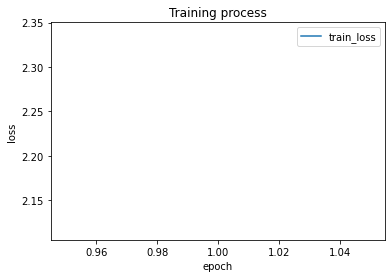

In [213]:
clf.fit(epochs=1)

--- CROSS VALIDATION | FOLD: 1 ---
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | Train_Loss : 2.2574892163276674


 50%|█████     | 1/2 [01:10<01:10, 70.26s/it]

Epoch: 1 | Valid_Loss : 2.0436060428619385
Epoch: 2 | Train_Loss : 1.8949442923069


100%|██████████| 2/2 [01:50<00:00, 55.04s/it]

Epoch: 2 | Valid_Loss : 1.7450995445251465


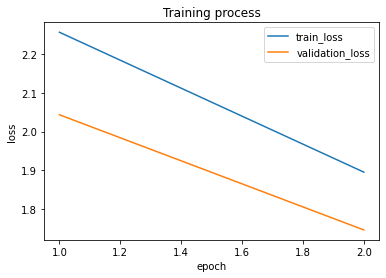

--- CROSS VALIDATION | FOLD: 2 ---
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
clf.cross_validation(epochs=2)